In [ ]:
%pip install pandas
%pip install sklearn
%pip install numpy
%pip install tensorflow
%pip install spacy

# **Exercise 10 with pretrained word embeding**

In [1]:
import numpy as np
import spacy
import requests
import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_recall_curve, auc, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


# Load the spaCy model with pre-trained word embeddings
word_embeddings = spacy.load("en_core_web_sm")

def download_and_read_data(file_url, size):
    response = requests.get(file_url)
    lines = response.text.splitlines()
    sentences = []
    current_sentence = []

    for line in lines:
        if line.startswith('#') or line == '':
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
                if(len(sentences) == size):
                    break
        else:
            parts = line.split('\t')
            if len(parts) > 3:
                current_sentence.append((parts[1], parts[3]))  # (word, pos_tag)
    return sentences if not current_sentence else sentences + [current_sentence]

# URLs
train_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu"
dev_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu"
test_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"

# Read and preprocess data
subset_size = 1000
train_data = download_and_read_data(train_url, subset_size)
dev_data = download_and_read_data(dev_url, int(subset_size/5))
test_data = download_and_read_data(test_url, int(subset_size/5))

# Extract words and POS tags
def extract_features(sentence, i):
    word = sentence[i][0]
    pos = sentence[i][1]

    # Features: the current word and its two neighbors
    features = [
        word,
        sentence[i - 1][0] if i > 0 else '*PAD*',
        sentence[i + 1][0] if i < len(sentence) - 1 else '*PAD*',
    ]
    return features, pos

# Create training, development, and test datasets
def create_dataset(data):
    X, y = [], []
    for sentence in data:
        for i in range(len(sentence)):
            features, pos = extract_features(sentence, i)
            X.append(features)
            y.append(pos)
    return X, y


X_train, y_train = create_dataset(train_data)
X_dev, y_dev = create_dataset(dev_data)
X_test, y_test = create_dataset(test_data)

X_train_embed = []
X_dev_embed = []
X_test_embed = []

# Convert words to spaCy word vectors
for dataset, X_embed in zip([X_train, X_dev, X_test], [X_train_embed, X_dev_embed, X_test_embed]):
    for sentence in tqdm.tqdm(range(len(dataset))):
        word_vectors = [word_embeddings(word).vector for word in dataset[sentence]]
        X_embed.append(np.array(word_vectors))


# Encode POS tags
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
num_classes = len(label_encoder.classes_)

y_train_encoded = label_encoder.transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)


# Convert tags to one-hot encoding
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_dev_onehot = to_categorical(y_dev_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

# constants
embedding_dim = word_embeddings('test').vector.shape[0]
max_sequence_length = 3

# statistics
print("Training set size:", len(train_data))
print("Development set size:", len(dev_data))
print("Test set size:", len(test_data))
lengths = [len(i) for i in train_data] + [len(i) for i in dev_data] + [len(i) for i in test_data]
print("Average sentence length: ", sum(lengths)/len(lengths))
words_set = set()
for sentences in zip([train_data, dev_data, test_data]):
    for sent in sentences:
        for w in sent:
            words_set.add(w[0])
print("NUmber of words: ", len(words_set))
print("Vocabulary size: ", len(word_embeddings.vocab))

100%|██████████| 4321/4321 [01:07<00:00, 64.43it/s]


Training set size: 1000
Development set size: 200
Test set size: 200
Average sentence length:  21.79
NUmber of words:  492
Vocabulary size:  6431


# **Find best hyperparameters**

In [8]:
def evaluate_model(hidden_units, dropout_rate, lr, epochs):
  model = Sequential()
  model.add(Flatten(input_shape=(max_sequence_length, embedding_dim)))
  model.add(Dense(hidden_units, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

  filepath = 'temp_best_model.hdf5'
  checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')
  callbacks = [checkpoint]

  history = model.fit(np.array(X_train_embed), y_train_onehot, epochs=epochs,
                      validation_data=(np.array(X_dev_embed), y_dev_onehot),
                      callbacks=callbacks, batch_size=32, verbose = 0)

  loss, accuracy = model.evaluate(np.array(X_dev_embed), y_dev_onehot)
  return accuracy, loss

def tune_hyperparam(params):
  best_acc = 0
  best_loss = 100
  best_params = ()
  for hdu in params["hidden_units"]:
    for dro in params["dropout_rate"]:
      for lr in params["learning_rate"]:
        for ep in params["epochs"]:
          print("Dev accuracy for params: ", (hdu, dro, lr, ep))
          acc, loss = evaluate_model(hdu, dro, lr, ep)
          if loss < best_loss or (loss == best_loss and acc > best_acc):
            best_acc = acc
            best_loss = loss
            best_params = (hdu, dro, lr, ep)

  return best_acc, best_loss, best_params

hyper_parameters = {
    "hidden_units": [64, 128, 256],
    "dropout_rate": [0.2, 0.4, 0.6],
    "learning_rate": [0.0001, 0.001, 0.01],
    "epochs": [100]
}

print(tune_hyperparam(hyper_parameters))

Dev accuracy for params:  (64, 0.2, 0.0001, 100)
128/128 [==============================] - 0s 3ms/step - loss: 0.1909 - accuracy: 0.9533
Dev accuracy for params:  (64, 0.2, 0.001, 100)
128/128 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.9474
Dev accuracy for params:  (64, 0.2, 0.01, 100)
128/128 [==============================] - 0s 3ms/step - loss: 1.4821 - accuracy: 0.9393
Dev accuracy for params:  (64, 0.4, 0.0001, 100)
128/128 [==============================] - 0s 2ms/step - loss: 0.1849 - accuracy: 0.9533
Dev accuracy for params:  (64, 0.4, 0.001, 100)
128/128 [==============================] - 0s 2ms/step - loss: 0.4524 - accuracy: 0.9503
Dev accuracy for params:  (64, 0.4, 0.01, 100)
128/128 [==============================] - 0s 3ms/step - loss: 1.4739 - accuracy: 0.9329
Dev accuracy for params:  (64, 0.6, 0.0001, 100)
128/128 [==============================] - 0s 3ms/step - loss: 0.1869 - accuracy: 0.9520
Dev accuracy for params:  (64, 0.6, 0.00

# **Build model**

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_31 (Flatten)        (None, 288)               0         
                                                                 
 dense_62 (Dense)            (None, 64)                18496     
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_63 (Dense)            (None, 18)                1170      
                                                                 
Total params: 19666 (76.82 KB)
Trainable params: 19666 (76.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
684/692 [============================>.] - ETA: 0s - loss: 2.0110 - accuracy: 0.4168
Epoch 1: val_loss improved from inf to 0.93126, savi

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


684/692 [============================>.] - ETA: 0s - loss: 0.8773 - accuracy: 0.7556
Epoch 2: val_loss improved from 0.93126 to 0.48383, saving model to best_model.hdf5
692/692 [==============================] - 3s 5ms/step - loss: 0.8763 - accuracy: 0.7560 - val_loss: 0.4838 - val_accuracy: 0.8812
Epoch 3/100
677/692 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.8384
Epoch 3: val_loss improved from 0.48383 to 0.35370, saving model to best_model.hdf5
692/692 [==============================] - 3s 4ms/step - loss: 0.5829 - accuracy: 0.8391 - val_loss: 0.3537 - val_accuracy: 0.9065
Epoch 4/100
679/692 [============================>.] - ETA: 0s - loss: 0.4528 - accuracy: 0.8720
Epoch 4: val_loss improved from 0.35370 to 0.30021, saving model to best_model.hdf5
692/692 [==============================] - 2s 4ms/step - loss: 0.4522 - accuracy: 0.8724 - val_loss: 0.3002 - val_accuracy: 0.9171
Epoch 5/100
682/692 [============================>.] - ETA: 0s - loss: 0.386

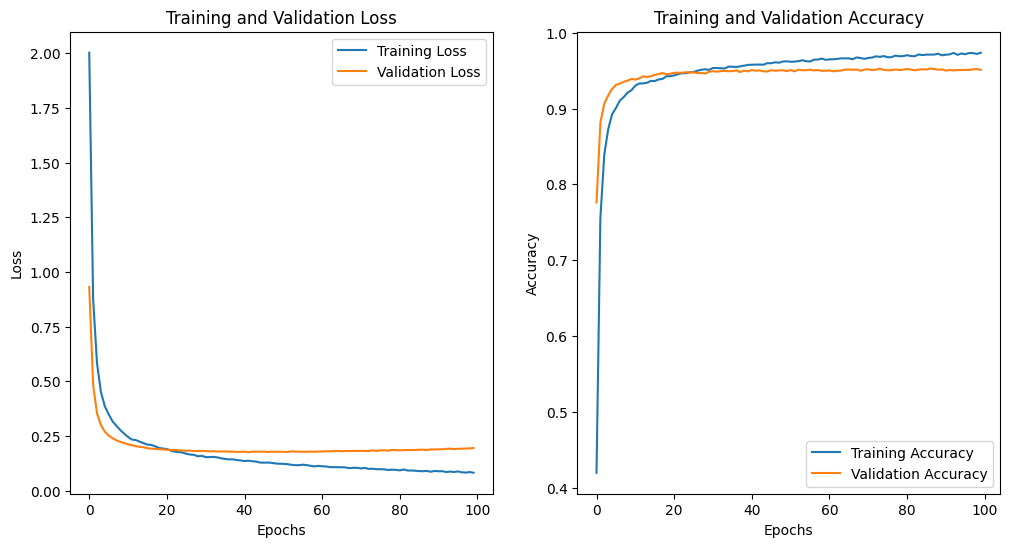

0


In [9]:
# Build the MLP model
hidden_units = 64
dropout_rate = 0.4
epochs = 100
learn_rate = 0.0001


model = Sequential()
model.add(Flatten(input_shape=(max_sequence_length, embedding_dim)))
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=learn_rate), loss='categorical_crossentropy', metrics=['accuracy'])

filepath = 'best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',
                            verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]


history = model.fit(np.array(X_train_embed), y_train_onehot, epochs=epochs,
                    validation_data=(np.array(X_dev_embed), y_dev_onehot),
                    callbacks=callbacks, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(np.array(X_test_embed), y_test_onehot)
print(f'\nTest Accuracy: {accuracy * 100:.2f}%')

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
loss_list = history.history['val_loss']
print("Min validation loss at epoch: ", loss_list.index(min(loss_list)), "->", min(loss_list))

Min validation loss at epoch:  41 -> 0.17597517371177673


# **Calculate metrics for MLP**

In [23]:
import pandas as pd


def calculate_metrics(custom_model, X, y):
  # X = X_test_embed, y = y_test_onehot
  y_pred_class = custom_model.predict(np.array(X))
  report = classification_report(np.argmax(y, axis=1), np.argmax(y_pred_class, axis=1), output_dict=True)
  n_classes = y.shape[1]

  # For each class
  for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y[:, i], y_pred_class[:, i])
    try:
      report[str(i)]["pr-auc"] = auc(recall, precision)
    except:
      report[str(i)] = {"precision": 0, "recall": 0, "f1-score": 0, "pr-auc": auc(recall, precision), "support": 0}

  # A "macro-average": quantifying score on all classes jointly
  precision, recall, _ = precision_recall_curve(y.ravel(), y_pred_class.ravel())
  report["macro avg"]["pr-auc"] = auc(recall, precision)
  report["accuracy"] = {"precision": '', "recall": '', "f1-score": report["accuracy"], "pr-auc": '', "support": 0}
  #del report["weighted avg"]

  pd.set_option('display.precision', 4)
  final_report = pd.DataFrame.from_dict(report).T
  final_report["support"] = final_report["support"].astype(int)
  final_report = final_report.reindex(columns=["precision", "recall", "f1-score", "pr-auc", "support"])
  return final_report


for name, X_set, y_set in zip(["Training", "Development", "Test"],
                              [X_train_embed, X_dev_embed, X_test_embed],
                              [y_train_onehot, y_dev_onehot, y_test_onehot]):
  print("\nMetrics for", name, "dataset:")
  print(calculate_metrics(model, X_set, y_set))


Metrics for Training dataset:
692/692 [==============================] - 1s 2ms/step
             precision  recall f1-score  pr-auc  support
0               0.9782  0.9674   0.9728  0.9953     1626
1               0.9791  0.9947   0.9868  0.9992     2259
2               0.9928  0.9796   0.9861  0.9981      979
3               0.9967  0.9992   0.9979  0.9999     1193
4               0.9985     1.0   0.9992     1.0      660
5                0.999   0.999    0.999     1.0     1942
6                  1.0  0.7407   0.8511  0.9123       27
7               0.9816  0.9759   0.9787  0.9972     3491
8               0.9968  0.9968   0.9968  0.9999      313
9               0.9983     1.0   0.9991     1.0      576
10              0.9976  0.9936   0.9956  0.9999     1252
11              0.9624  0.9844   0.9733  0.9952     2311
12              0.9996  0.9996   0.9996     1.0     2551
13               0.972  0.9095   0.9397  0.9859      420
14                 1.0  0.9474    0.973     1.0       19
15

# **Baseline Classifier and metrics**

In [4]:
flatten = lambda l: [item for sublist in l for item in sublist]

# Flatten and extract words and POS tags
train_flat = flatten(train_data)
train_words, train_tags = zip(*train_flat)
dev_flat = flatten(dev_data)
dev_words, dev_tags = zip(*dev_flat)
test_flat = flatten(test_data)
test_words, test_tags = zip(*test_flat)


class Majority_Classifier:
  def __init__(self):
    self.most_common_tag = None
    self.words = []
    self.tags = []
    self.label_encoder = LabelEncoder()
    self.num_classes = 0

  def fit(self, training_data):
    tag_counter = Counter(training_data)
    self.most_common_tag = tag_counter.most_common(1)[0][0][1]
    for word in tag_counter.keys():
      self.words.append(word[0])
      self.tags.append(word[1])

    self.label_encoder.fit(self.tags)
    self.num_classes = len(label_encoder.classes_)

    del tag_counter

  def predict(self, data):
    data, _ = zip(*data)
    predictions = []
    for word in data:
      try:
        pred_tag = self.tags[self.words.index(word)]
      except:
        pred_tag = self.most_common_tag
      predictions.append(pred_tag)
    return to_categorical(self.label_encoder.transform(predictions), self.num_classes)

majority = Majority_Classifier()
majority.fit(train_flat)

train_tags = to_categorical(majority.label_encoder.transform(train_tags), majority.num_classes)
dev_tags = to_categorical(majority.label_encoder.transform(dev_tags), majority.num_classes)
test_tags = to_categorical(majority.label_encoder.transform(test_tags), majority.num_classes)


for name, X_set, y_set in zip(["Training", "Development", "Test"],
                              [train_flat, dev_flat, test_flat],
                              [train_tags, dev_tags, test_tags]):
  print("\nMetrics for", name, "dataset:")
  print(calculate_metrics(majority, X_set, y_set))


Metrics for Training dataset:
             precision  recall f1-score  pr-auc  support
0               0.9482  0.9459    0.947   0.949     1626
1               0.9143  0.8645   0.8887  0.8964     2259
2               0.8909   0.859   0.8747  0.8781      979
3               0.8051  0.8692    0.836  0.8407     1193
4               0.9939  0.9879   0.9909  0.9911      660
5               0.9775  0.9398   0.9583  0.9613     1942
6                 0.88  0.8148   0.8462  0.8475       27
7               0.9659   0.957   0.9614  0.9648     3491
8               0.9965  0.9201   0.9568  0.9589      313
9               0.6867  0.7917   0.7355  0.7419      576
10              0.9331  0.9137   0.9233  0.9259     1252
11              0.9879  0.9905   0.9892  0.9897     2311
12              0.9926     1.0   0.9963  0.9963     2551
13              0.5245  0.6381   0.5757  0.5847      420
14                 1.0  0.2105   0.3478  0.6056       19
15              0.8927  0.9065   0.8995  0.9042     2193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif